In [48]:
import os
import pickle
from typing import Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nbimporter
from GridWorld_environments import Grid_World
from BIRL_Arena_Notebook import train_value_iteration

In [107]:
def compute_reward_loss(target_reward: np.ndarray, predicted_reward: np.ndarray):
    
#     diff = target_reward - predicted_reward
    
#     return np.sum(diff**2)

    return np.linalg.norm(target_reward - predicted_reward, ord=2)


def compute_policy_loss(target_value_func: Dict[Any, float], predicted_value_func: Dict[Any, float], env_size):
    
#     diff = []
    
#     for state in target_value_func:
#         diff.append(target_value_func[state] - predicted_value_func[state])
    
#     return np.sum(diff)
    
    # val func: dict -> np.array
    expert_greedy_dict_val_func = target_value_func
    expert_greedy_val_func = np.zeros(env_size)
    for state in expert_greedy_dict_val_func:
        expert_greedy_val_func[state] = expert_greedy_dict_val_func[state]
    predicted_policy_dict_val_func = predicted_value_func
    predicted_policy_val_func = np.zeros(env_size)
    for state in predicted_policy_dict_val_func:
        predicted_policy_val_func[state] = predicted_policy_dict_val_func[state]
        
    return np.linalg.norm(expert_greedy_val_func - predicted_policy_val_func, ord=1)
    

In [108]:
arr_1 = np.array([[1.0, 0.0],
                  [0.0, 0.0]])
arr_2 = np.array([[0.9, 0.1],
                  [0.1, 0.1]])

compute_reward_loss(arr_1, arr_2)

0.2

In [109]:
reward_loss_df = pd.DataFrame()
policy_loss_df = pd.DataFrame()

## BIRL
BIRL_file_suffix = "BIRL_"

reward_loss_dict = {}
policy_loss_dict = {}

for file in os.listdir("data"):
    if file.startswith(BIRL_file_suffix):
        print(f"Found BIRL data file {file}")
        with open(os.path.join("data", file), 'rb') as f:
            loaded_dict = pickle.load(f)
            
        n_of_states = loaded_dict["metadata"]["env_n_of_states"]
        predicted_rewards_mean = np.mean(loaded_dict["data"]["predicted_rewards"], axis=0)
        
        # get the policy and value fucntion that optimize the predicted reward
        env = Grid_World(size=loaded_dict["metadata"]["env_size"],
                         traps=loaded_dict["metadata"]["env_traps"],
                         goals=loaded_dict["metadata"]["env_goals"])
        env.set_board(predicted_rewards_mean)
        predicted_policy, predicted_value_func = train_value_iteration(gw_env=env,
                                                                       gamma=loaded_dict["metadata"]["gamma"],
                                                                       training_iterations=1000)
        
        reward_loss_dict[n_of_states] = compute_reward_loss(loaded_dict["data"]["target_reward"],
                                                            predicted_rewards_mean)
        policy_loss_dict[n_of_states] = compute_policy_loss(loaded_dict["data"]["expert_greedy_val_func"],
                                                            predicted_value_func, loaded_dict['metadata']['env_size'])

reward_loss_df["BIRL"] = pd.Series(reward_loss_dict).sort_index()
policy_loss_df["BIRL"] = pd.Series(policy_loss_dict).sort_index()


## IRL
IRL_file_suffix = "IRL_"

reward_loss_dict = {}
policy_loss_dict = {}

for file in os.listdir("data"):
    if file.startswith(IRL_file_suffix):
        print(f"Found IRL data file {file}")
        with open(os.path.join("data", file), 'rb') as f:
            loaded_dict = pickle.load(f)
            
        n_of_states = loaded_dict["metadata"]["env_n_of_states"]
        predicted_reward = loaded_dict["data"]["predicted_rewards"]
        
        # get the policy and value fucntion that optimize the predicted reward
        env = Grid_World(size=loaded_dict["metadata"]["env_size"],
                         traps=loaded_dict["metadata"]["env_traps"],
                         goals=loaded_dict["metadata"]["env_goals"])
        env.set_board(predicted_reward)
        predicted_policy, predicted_value_func = train_value_iteration(gw_env=env,
                                                                       gamma=loaded_dict["metadata"]["gamma"],
                                                                       training_iterations=1000)
        
        reward_loss_dict[n_of_states] = compute_reward_loss(loaded_dict["data"]["target_reward"],
                                                            predicted_reward)
        policy_loss_dict[n_of_states] = compute_policy_loss(loaded_dict["data"]["expert_greedy_val_func"],
                                                            predicted_value_func, loaded_dict['metadata']['env_size'])

reward_loss_df["IRL"] = pd.Series(reward_loss_dict).sort_index()
policy_loss_df["IRL"] = pd.Series(policy_loss_dict).sort_index()


Found BIRL data file BIRL_4.pkl
Found BIRL data file BIRL_1.pkl
Found BIRL data file BIRL_2.pkl
Found BIRL data file BIRL_3.pkl
Found IRL data file IRL_3.pkl
Found IRL data file IRL_2.pkl
Found IRL data file IRL_1.pkl
Found IRL data file IRL_4.pkl


In [110]:
reward_loss_df

,BIRL,IRL
9,2.185645,8.722279
20,3.404705,21.143001
49,5.681638,50.706020
100,6.539665,90.161552


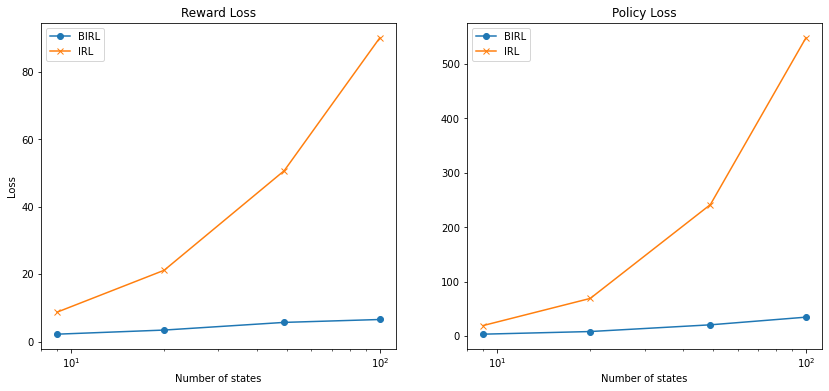

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

reward_loss_df.BIRL.plot(ax=ax[0], marker='o')
reward_loss_df.IRL.plot(ax=ax[0], marker='x')

ax[0].set_xscale("log")

ax[0].set_title("Reward Loss")
ax[0].set_xlabel("Number of states")
ax[0].set_ylabel("Loss")
ax[0].legend()

policy_loss_df.BIRL.plot(ax=ax[1], marker='o')
policy_loss_df.IRL.plot(ax=ax[1], marker='x')

ax[1].set_xscale("log")

ax[1].set_title("Policy Loss")
ax[1].set_xlabel("Number of states")
# ax[1].set_ylabel("Loss")
ax[1].legend()

# plt.show()
plt.savefig("loss_plots.png", dpi=400)

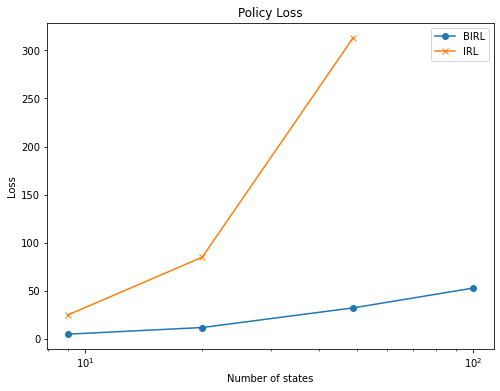

In [88]:
fig, ax = plt.subplots(figsize=(8, 6))

policy_loss_df.BIRL.plot(marker='o')
policy_loss_df.IRL.plot(marker='x')

ax.set_xscale("log")

ax.set_title("Policy Loss")
ax.set_xlabel("Number of states")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

In [67]:
loaded_dict

{'metadata': {'algorithm': 'IRL - Q Learning',
  'environment': 'Grid_World',
  'env_n_of_states': 49,
  'env_size': (7, 7),
  'env_traps': [],
  'env_goals': [(0, 0)],
  'gamma': 0.95,
  'expert_n_of_trajs': 980,
  'expert_max_traj_length': 196},
 'data': {'target_reward': array([[1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]),
  'predicted_rewards': array([[-4.37878956, -5.2979431 , -5.90284409, -6.18918165, -6.18918165,
          -5.90284409, -5.2979431 ],
         [-5.2979431 , -6.41003653, -7.14191255, -7.48835533, -7.48835533,
          -7.14191255, -6.41003653],
         [-5.90284409, -7.14191255, -7.95735166, -8.34335009, -8.34335009,
          -7.95735166, -7.14191255],
         [-6.18918165, -7.48835533, -8.34335009, -8.7480727 , -8.7480727 ,
          -8.3433500

Found 3 files for expirements of IRL data


Text(0.5, 1.0, 'policy loss')

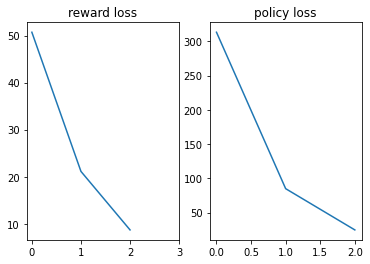

In [77]:
IRL_file_suffix = "IRL_"
BIRL_file_suffix = "BIRL_"

# find largest file number of BIRL file in "data" folder
largest_file_number = 0

experiments = []
file_counter = 0

for file in os.listdir("data"):
    #print(file)
    if ( IRL_file_suffix in file ) and ( BIRL_file_suffix not in file ):
        pass
        with open(os.path.join("data", file), 'rb') as file:
            experiments.append(pickle.load(file))
            file_counter += 1

print(f"Found {file_counter} files for expirements of IRL data")

reward_loss = []
policy_loss = []

for exp in experiments:
    
    # val func: dict -> np.array
    expert_greedy_dict_val_func = exp['data']['expert_greedy_val_func']
    expert_greedy_val_func = np.zeros(exp['metadata']['env_size'])
    for state in expert_greedy_dict_val_func:
        expert_greedy_val_func[state] = expert_greedy_dict_val_func[state]
    predicted_policy_dict_val_func = exp['data']['predicted_policy_val_func']
    predicted_policy_val_func = np.zeros(exp['metadata']['env_size'])
    for state in predicted_policy_dict_val_func:
        predicted_policy_val_func[state] = predicted_policy_dict_val_func[state]
    
    reward_loss.append(np.linalg.norm(exp['data']['target_reward'] - exp['data']['predicted_rewards'], ord=2))
    policy_loss.append(np.linalg.norm(expert_greedy_val_func - predicted_policy_val_func, ord=1))

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(reward_loss)
axs[0].set_title('reward loss')
axs[0].set_xticks([0,1,2,3])
axs[1].plot(policy_loss)
axs[1].set_title('policy loss')
#print(experiments)

In [42]:
24 * 60 * 60


86400